# Задача 2. Линейная регрессия, метод градиентного спуска.

- [x] Самостоятельно реализовать функцию **gradient_descent(X, y)**, которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал **методом градиентного спуска (Batch Gradient Descent, GD)** и возвращая вектор весов **w**. В качестве функционала можно выбрать, например, функцию ошибок **MSE** + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.
- [x] Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин [тут](https://github.com/rustam-azimov/ml-course-itmo/tree/main/data/car_price) (целевой признак для предсказания --- **price**).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Случайным образом разбить данные на **обучающую** и **тестовую** выборки, используя методы существующих библиотек.
- [x] При обучении моделей использовать **масштабирование данных**.
- [x] Обучить модель на обучающей выборке, используя функцию **gradient_descent(X, y)**. Оценить качество модели на обучающей и тестовой выборках, используя **MSE**, **RMSE** и $R^2$.
- [x] Обучить модель, используя существующую библиотеку. Например, в **sklearn** для $L_2$-регуляризатора можно использовать **Ridge**. Сравнить качество с Вашей реализацией.
- [x] Повторить то же самое, но используя **кросс-валидацию**.
- [x] Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, **E** --- мат. ожидание и **STD** --- стандартное отклонение. Сделать выводы.

#### Доп. задачи
- [x] (+2 балла) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя **Recursive Feature Elimination (RFE)** из **sklearn**.
- [x] (+1 балл) Во все ваши реализации добавить возможность настройки нужных **гиперпараметров**, а в процессе обучения **всех** моделей осуществить подбор оптимальных значений этих гиперпараметров.
- [x] (+1 балл) Также самостоятельно реализовать **метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD)**, обучить модели и добавить их во все сравнения.
- [x] (+1 балл) Также самостоятельно реализовать **метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent)**, обучить модели и добавить их во все сравнения.

## Модель линейной регрессии

Модель линейной регрессии
$$ f(x) = \sum_{i=1}^{n} (x_i * w_i) + c $$
Для упрощения можно добавить к вектору входных данных $x$ единичку и увеличить размер вектора весов на единичку, это позволит избавиться от константы $c$. Ниже написан код имитирующий модель линейной регрессии.

In [229]:
import numpy as np

def add_ones_vector(samples):
    samples_matrix = samples.copy()
    if samples.ndim == 1:
        samples_matrix = samples_matrix.reshape(-1, 1)

    ones_vec = np.ones((samples_matrix.shape[0], 1))
    return np.hstack([ones_vec, samples_matrix])

def linear_model(w, x):
    return np.matmul(add_ones_vector(x), w)

## Градиентный спуск

Реализация градиентного спуска, стохастического градиентного спуска и мини-пакетного градиентного спуска для модели линейной регрессии с функцией ошибок MSE и $L_2$-регуляризатором.

In [230]:
class GDLinearRegression:
    def __init__(self, tol=1E-4, alpha=1, step_coef=1E-2, max_iterations=10_000):
        self.w = None
        self.tol = tol
        self.alpha = alpha
        self.step_coef = step_coef
        self.max_iter = max_iterations

    def fit(self, X, y):
        features_num = np.shape(X)[1]
        X_sample = add_ones_vector(X)
        w = np.random.randn(features_num + 1, )

        step = 0
        while step < self.max_iter:
            y_pred = X_sample.dot(w)
            error = y_pred - y

            grad = (1 / X_sample.shape[0]) * (X_sample.T.dot(error) + self.alpha * w)
            diff = self.step_coef * grad
            w -= diff

            step += 1
            if np.all(np.abs(diff) <= self.tol):
                break
        self.w = w

    def predict(self, x):
        return linear_model(self.w, x)

In [231]:
class SGDLinearRegression:

    def __init__(self, tol=1E-4, alpha=1, step_coef=1E-2, max_iterations=10_000):
        self.w=None
        self.tol=tol
        self.alpha=alpha
        self.step_coef = step_coef
        self.max_iter = max_iterations

    def fit(self, X, y):
        samples_num = np.shape(X)[0]
        features_num = np.shape(X)[1]
        X_sample = add_ones_vector(X)
        w = np.random.randn(features_num + 1, )

        step = 0
        while step < self.max_iter:
            rnd_i = np.random.randint(0, samples_num)

            x_batch, y_batch = X_sample[rnd_i, :].reshape(1, features_num + 1), y[rnd_i]
            y_pred = x_batch.dot(w)
            error = y_pred - y_batch

            grad = (1 / x_batch.shape[0]) * (x_batch.T.dot(error) + self.alpha * w)
            diff = self.step_coef * grad
            w -= diff

            step += 1
            if np.all(np.abs(diff) <= self.tol):
                break
        self.w = w

    def predict(self, x):
        return linear_model(self.w, x)

In [232]:
class MiniBatchGDLinearRegression:

    def __init__(self, tol=1E-4, alpha=1, step_coef=1E-2, batch_size=10, max_iterations=10_000):
        self.w=None
        self.tol=tol
        self.alpha=alpha
        self.step_coef = step_coef
        self.max_iter = max_iterations
        self.batch_size = batch_size

    def fit(self, X, y):
        samples_num = np.shape(X)[0]
        features_num = np.shape(X)[1]
        X_sample = add_ones_vector(X)
        w = np.random.randn(features_num + 1, )

        step = 0
        while step < self.max_iter:
            all_indices = np.arange(samples_num)
            np.random.shuffle(all_indices)

            num_batch = samples_num // self.batch_size
            batch_indices = np.array_split(all_indices, num_batch)

            diff = self.tol + 1
            for i in range(num_batch):
                x_batch, y_batch = X_sample[batch_indices[i]].reshape(len(batch_indices[i]), features_num + 1), y[batch_indices[i]]
                y_pred = x_batch.dot(w)
                error = y_pred - y_batch

                grad = (1 / x_batch.shape[0]) * (x_batch.T.dot(error) + self.alpha * w)
                diff = self.step_coef * grad
                w -= diff
                if np.all(np.abs(diff) <= self.tol):
                    break
            step += 1
            if np.all(np.abs(diff) <= self.tol):
                break
        self.w = w

    def predict(self, x):
        return linear_model(self.w, x)

## Подготовка датасета

Был выбран датасет [car_price](https://www.kaggle.com/datasets/hellbuoy/car-price-prediction/data)

Признаки:
* car_ID --- номер строки в датасете
* symboling --- символ отвечающий за уровень риска авто (чем ниже, тем безопаснее)
* CarName --- наименование машины
* fueltype --- тип топлива, которое использует машина
* aspiration --- тип наддува
* doornumber --- количество дверей
* carbody --- тип кузова
* drivewheel --- тип привода
* enginelocation --- расположение мотора
* wheelbase --- колёсная база автомобиля в дюймах
* carlenght --- длина автомобиля в дюймах
* carwidth --- ширина автомобиля в дюймах
* curbweight --- вес автомобиля в фунтах
* enginetype --- тип двигателя автомобиля
* cylindernumber --- количество цилиндров в двигателе
* enginesize --- размер двигателя в кубических дюймах
* fuelsystem --- тип топливной системы
* boreratio --- соотношение диаметра цилиндра и хода
* stroke --- расстояние, проходимое поршнем за каждый цикл
* compessionratio --- соотношение объема цилиндра с поршнем в нижнем положении (наибольший объем) и в верхнем положении (наименьший объем)
* horsepower --- количество лошадиных сил
* peakrpm --- максимальное количество оборотов в минуту
* citympg --- расход топлива в городе (миль на галлон)
* highwaympg --- расход топлива на трассе (миль на галлон)
* **price** --- цена автомобиля (целевой признак)

In [233]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("car_price.csv")
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [234]:
df = df.drop(columns=["car_ID"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

Пропущенных значений нет, но присутствует множество категориальных значений, которые необходимо будет перекодировать в численные.

## EDA

Преобразуем названия машин в их компанию производитель

In [235]:
df['CarName'] = df['CarName'].str.split(' ').str[0]

Некоторые компании по разному записаны, унифицируем их названия

In [236]:
df['CarName'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

In [237]:
df['CarName'] = df['CarName'].replace({'maxda': 'mazda', 'nissan': 'Nissan', 'porcshce': 'porsche', 'toyouta': 'toyota',
                            'vokswagen': 'volkswagen', 'vw': 'volkswagen'})

Построим сводные графики по всем признакам.

<Axes: xlabel='price', ylabel='Count'>

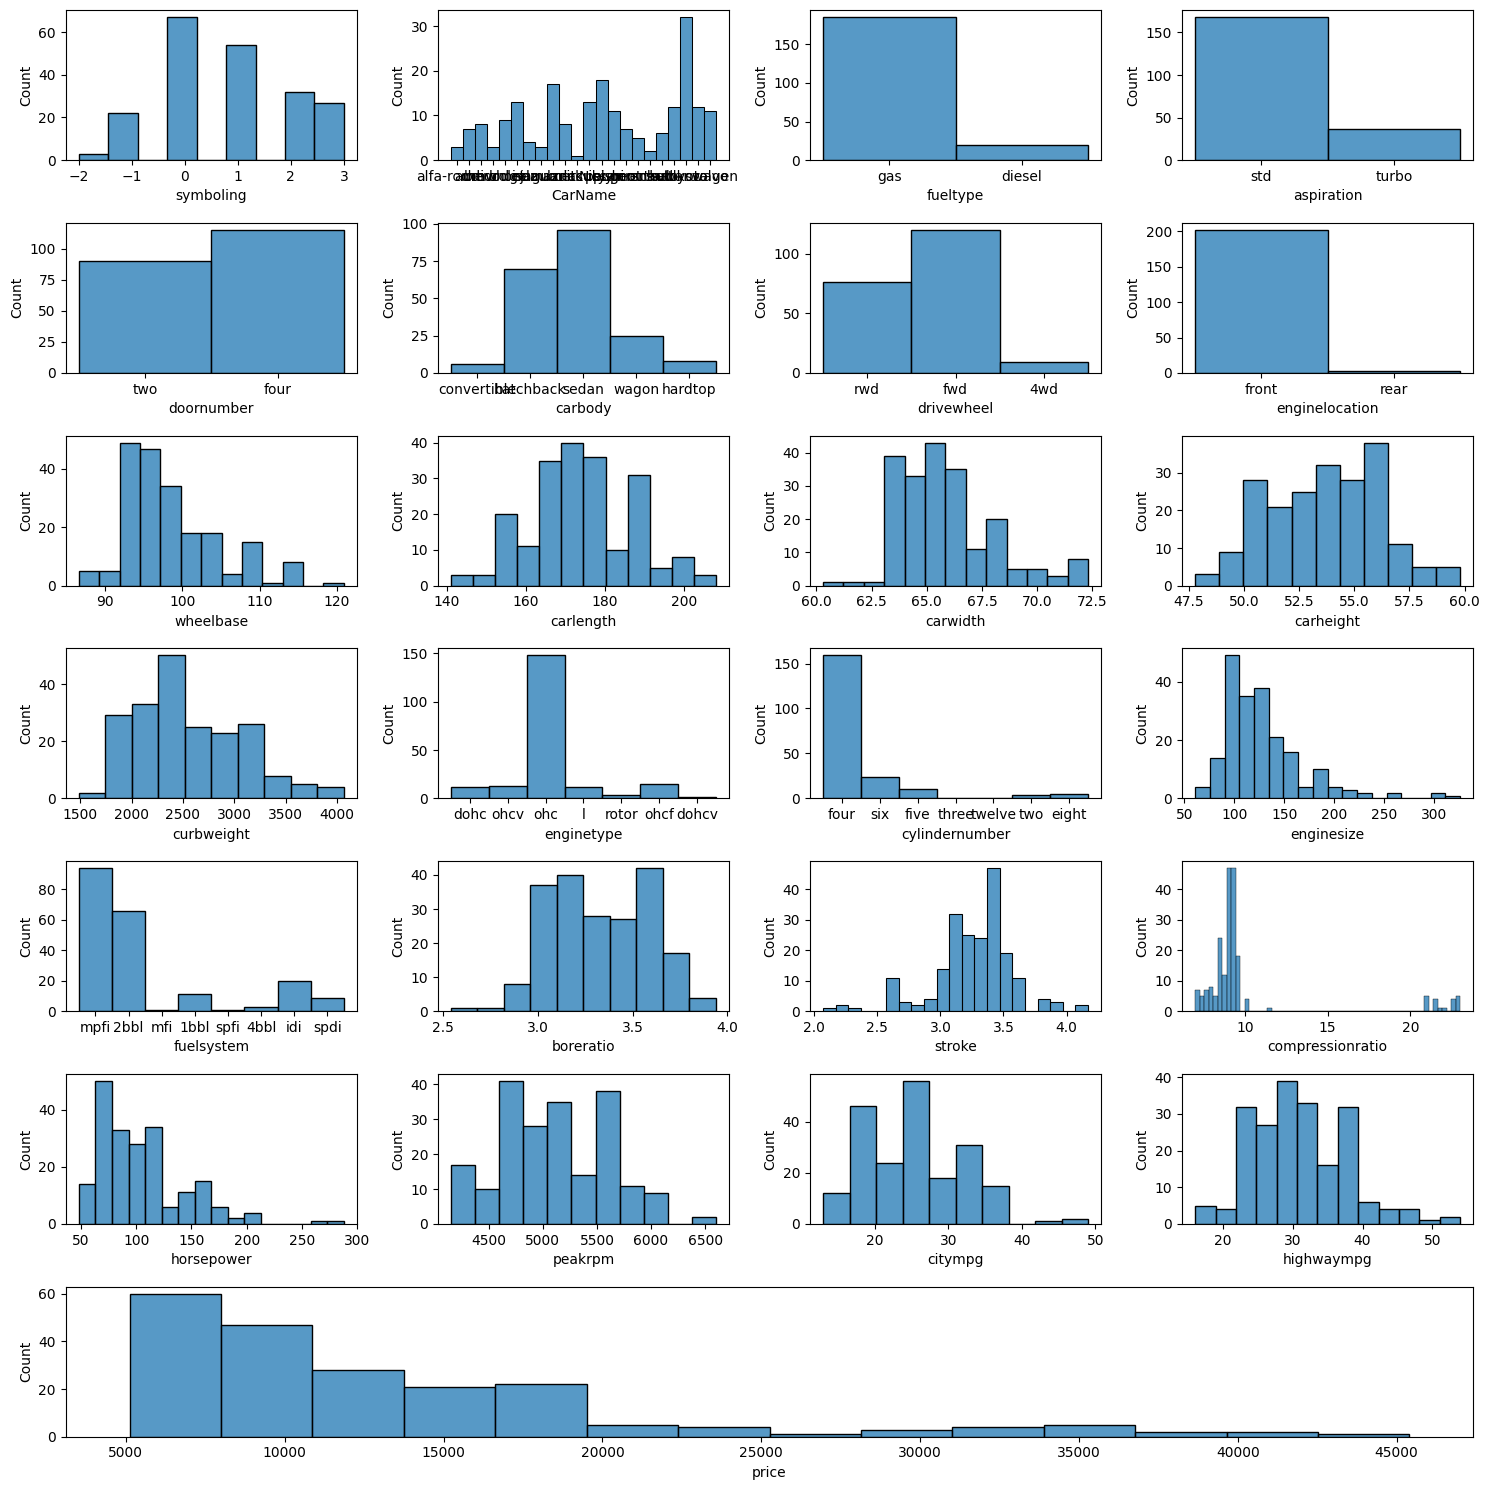

In [238]:
fig = plt.figure(figsize=(15, 15), tight_layout=True)
gs = fig.add_gridspec(7, 4)
for i in range(6):
    for j in range(4):
        sns.histplot(df[df.columns[4 * i + j]], ax=fig.add_subplot(gs[i, j]))
sns.histplot(df["price"], ax=fig.add_subplot(gs[6, :]))

Практически все машины используют газ вместо дизиля и имеют двигатель установленный спереди. Также тип двигателя в основном это ohc (overhead camshaft). Также можно сказать, что в датасете мало "премиумных" автомобилей и средняя цена не превосходит 20000.

Проверим зависимость цены автомобиля от его марки

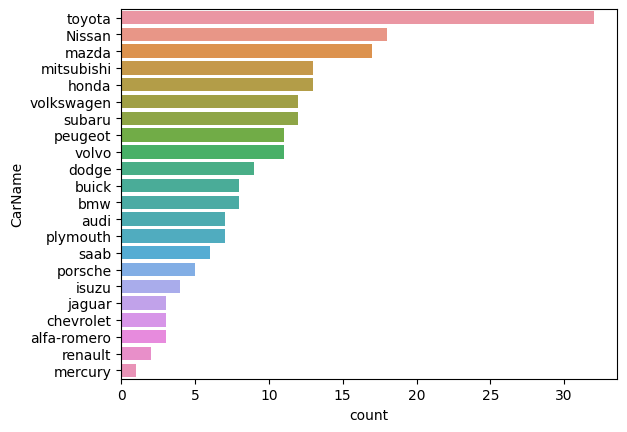

In [239]:
car_name_df = df['CarName'].value_counts().reset_index().rename(columns={'index':'CarName','CarName': 'count'})
plot = sns.barplot(y='CarName', x='count', data=car_name_df)

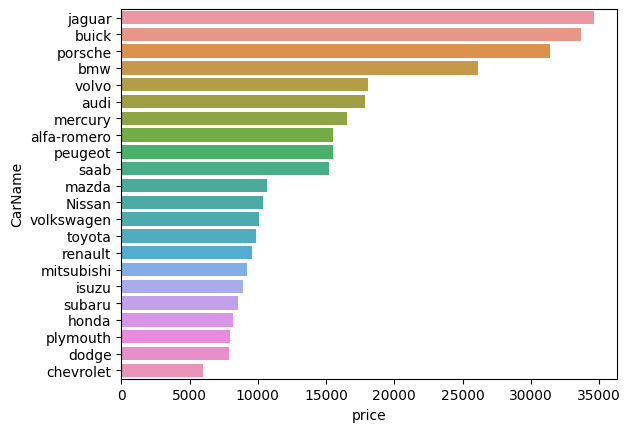

In [240]:
price_car_df = df[["CarName", "price"]].groupby(['CarName'], group_keys=False).mean()
price_car_df = price_car_df.reset_index().sort_values(by=["price"], ascending=False)
plot = sns.barplot(y='CarName', x='price', data=price_car_df)

Из графиков видно, что машин дороже 20000 в датасете мало (4 марки, которые находятся в нижней половине таблицы количества машин) и у них большой и резкий отрыв от предыдущих марок.

Также проверим виляние на цену признаков, в которых почти все значения принадлежат к одному классу (столбцы `enginelocation`, `cylindernumber`, `enginetype`, `fueltype`, `aspiration`)

<Axes: xlabel='enginetype', ylabel='price'>

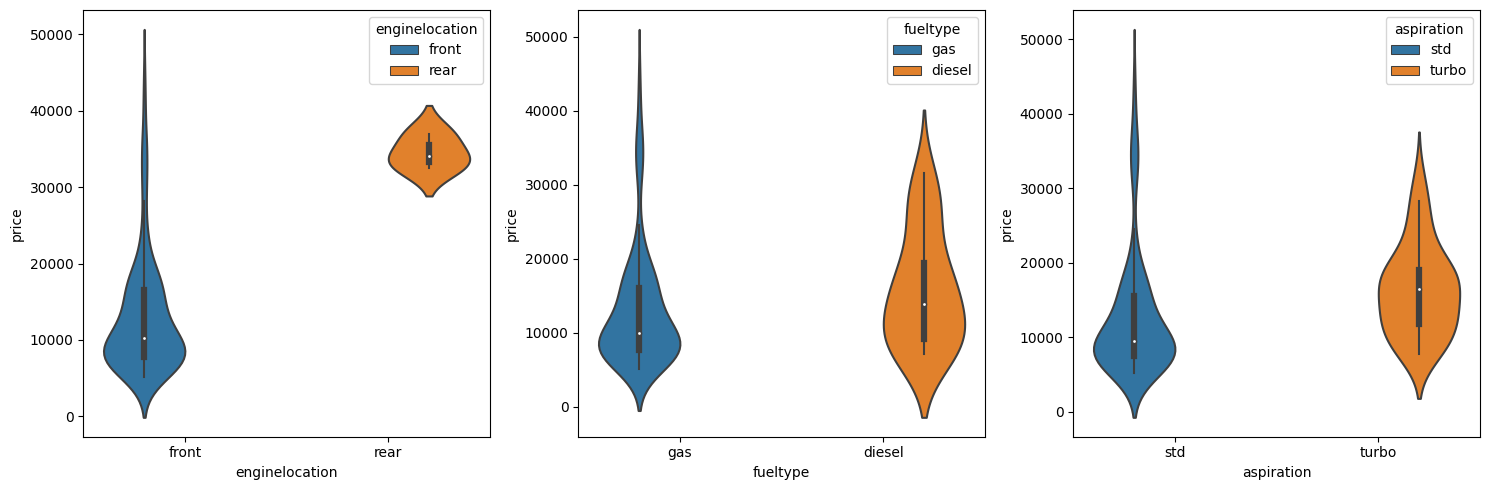

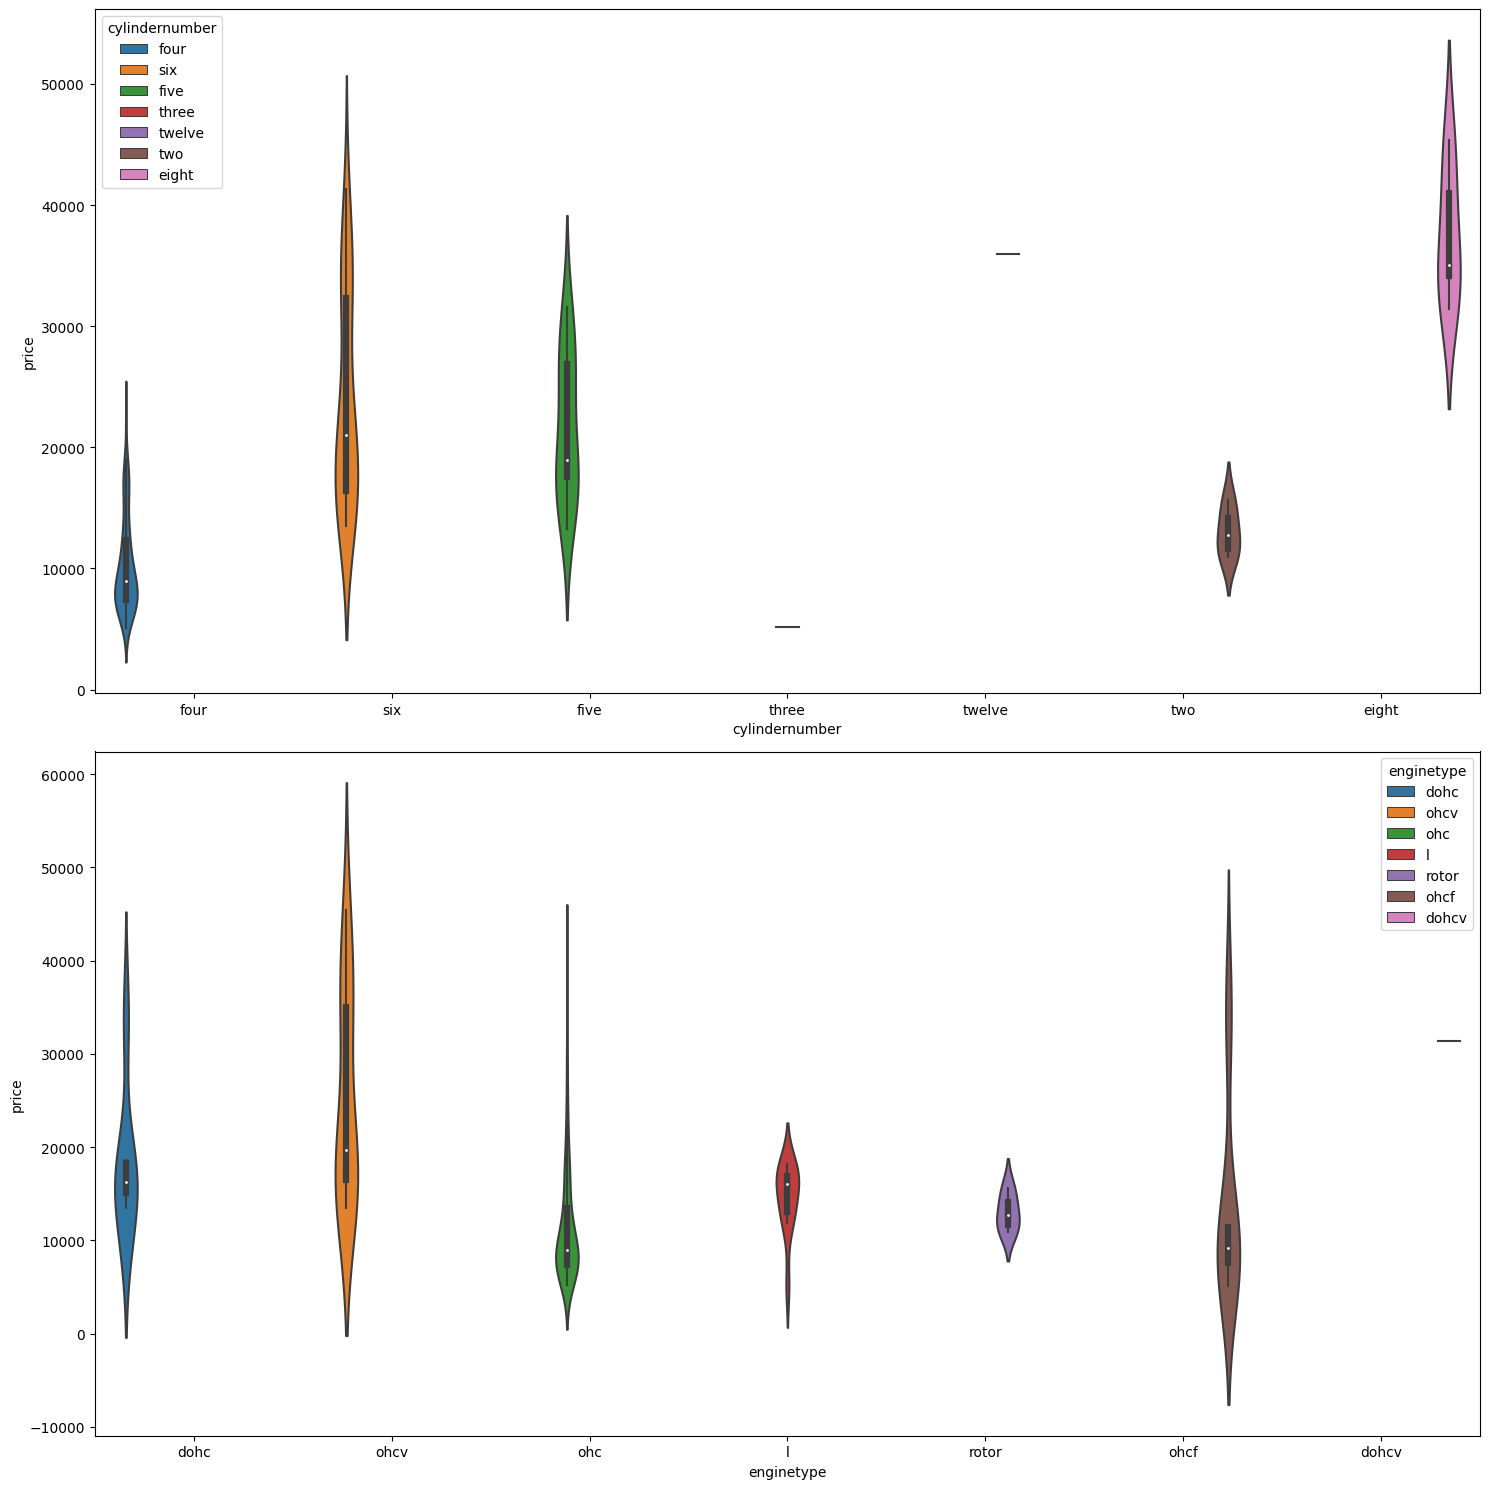

In [241]:
fig = plt.figure(figsize=(15, 5), tight_layout=True)
gs = fig.add_gridspec(1, 3)
sns.violinplot(df, x="enginelocation", y="price", hue="enginelocation", legend=None, ax=fig.add_subplot(gs[0, 0]))
sns.violinplot(df, x="fueltype", y="price", hue="fueltype", legend=None, ax=fig.add_subplot(gs[0, 1]))
sns.violinplot(df, x="aspiration", y="price", hue="aspiration", legend=None, ax=fig.add_subplot(gs[0, 2]))

fig = plt.figure(figsize=(15, 15), tight_layout=True)
gs = fig.add_gridspec(2, 1)
sns.violinplot(df, x="cylindernumber", y="price", hue="cylindernumber", legend=None, ax=fig.add_subplot(gs[0, 0]))
sns.violinplot(df, x="enginetype", y="price", hue="enginetype", legend=None, ax=fig.add_subplot(gs[1, 0]))

Редкие категории в среднем стоят дороже, чем распространённые, поэтому просто отказаться от них нельзя

Посмотрим корреляцию аттрибутов, возможно некоторые из них полностью выражаются через другие и тогда можно будет уменьшить количество признаков

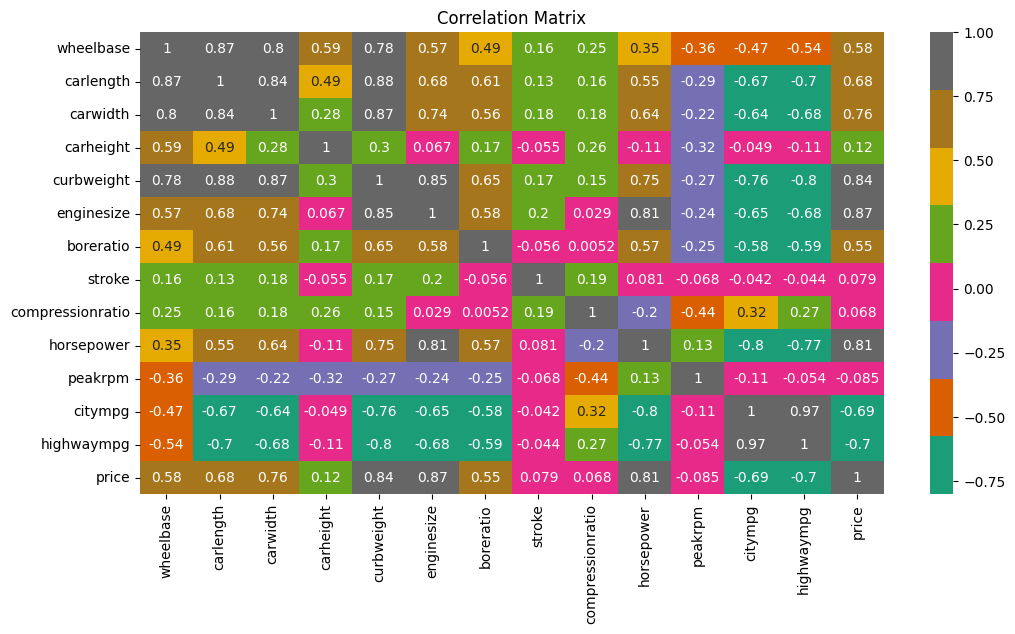

In [242]:
df_corr = df.drop(columns=["symboling"]).corr(numeric_only=True)  # sybmboling --- категориальный признак
plt.figure(figsize=(12, 6))
sns.heatmap(df_corr, annot=True, cmap="Dark2")
plt.title("Correlation Matrix")
plt.show()

Как видно из матрицы корреляции очень много признаков сильно связаны друг с другом, в частности `price` не коррелирует только с `carheight`, `stroke`, `compressionratio`, `peakrpm`

In [243]:
x_full, y = df.drop(columns=["price"]), df["price"]
df_strong_corr = x_full.drop(columns=["carheight", "stroke", "compressionratio", "peakrpm"])
df_weak_correlation = x_full[["carheight", "stroke", "compressionratio", "peakrpm"]]

In [291]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

x = x_full.copy()
categorical_cols = x.select_dtypes(include=['object']).columns

for col in categorical_cols:
    x[col] = le.fit_transform(x[col])

x.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,3,1,1,0,1,0,2,0,88.6,168.8,...,2,130,5,3.47,2.68,9.0,111,5000,21,27
1,3,1,1,0,1,0,2,0,88.6,168.8,...,2,130,5,3.47,2.68,9.0,111,5000,21,27
2,1,1,1,0,1,2,2,0,94.5,171.2,...,3,152,5,2.68,3.47,9.0,154,5000,19,26
3,2,2,1,0,0,3,1,0,99.8,176.6,...,2,109,5,3.19,3.40,10.0,102,5500,24,30
4,2,2,1,0,0,3,0,0,99.4,176.6,...,1,136,5,3.19,3.40,8.0,115,5500,18,22


## Маштабирование признаков

In [292]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
x.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,1.743470,-1.541331,0.328798,-0.469295,1.130388,-3.050975,1.213330,-0.121867,-1.690772,-0.426521,...,-0.147475,0.074449,0.869568,0.519071,-1.839377,-0.288349,0.174483,-0.262960,-0.646553,-0.546059
1,1.743470,-1.541331,0.328798,-0.469295,1.130388,-3.050975,1.213330,-0.121867,-1.690772,-0.426521,...,-0.147475,0.074449,0.869568,0.519071,-1.839377,-0.288349,0.174483,-0.262960,-0.646553,-0.546059
2,0.133509,-1.541331,0.328798,-0.469295,1.130388,-0.717207,1.213330,-0.121867,-0.708596,-0.231513,...,1.112210,0.604046,0.869568,-2.404880,0.685946,-0.288349,1.264536,-0.262960,-0.953012,-0.691627
3,0.938490,-1.395654,0.328798,-0.469295,-0.884652,0.449677,-0.589081,-0.121867,0.173698,0.207256,...,-0.147475,-0.431076,0.869568,-0.517266,0.462183,-0.035973,-0.053668,0.787855,-0.186865,-0.109354
4,0.938490,-1.395654,0.328798,-0.469295,-0.884652,0.449677,-2.391492,-0.121867,0.107110,0.207256,...,-1.407161,0.218885,0.869568,-0.517266,0.462183,-0.540725,0.275883,0.787855,-1.106241,-1.273900


## Выбор наилучшего подмножества признаков

In [293]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

rfecv = RFECV(estimator=LinearRegression())
rfecv.fit(x, y)

best_cols = list(x.columns[rfecv.support_])
print("Достаточное число признаков:", rfecv.n_features_)
print("Самые важные признаки:", *best_cols)

#
# В ходе ручных наблюдений с одним признаком 'enginesize' у всех моделей были хорошие,
# но одинаковые результаты, поэтому добавил ещё ранги до 4
#



Достаточное число признаков: 1
Самые важные признаки: enginesize


In [294]:
for rank, feature in sorted(zip(rfecv.ranking_, x.columns.values)):
    if rank > 4:
        break
    if rank == 1:
        continue
    best_cols.append(feature)
print("Выбранные признаки:", *best_cols)

Выбранные признаки: enginesize carwidth enginelocation curbweight


In [295]:
x = x[best_cols]
x.head()

,enginesize,carwidth,enginelocation,curbweight
0,0.074449,-0.844782,-0.121867,-0.014566
1,0.074449,-0.844782,-0.121867,-0.014566
2,0.604046,-0.190566,-0.121867,0.514882
3,-0.431076,0.136542,-0.121867,-0.420797
4,0.218885,0.230001,-0.121867,0.516807


## Разбиение данных на тренировные и тестовые

In [296]:
from sklearn.model_selection import train_test_split

x_np = x.to_numpy()
y_np = y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

## Подбор гиперпараметров

In [297]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

alpha_grid = np.logspace(-3, 3, 200)
tol_grid = np.logspace(-4, 1, 10)


searcher = GridSearchCV(
    Ridge(),
    [{"alpha": alpha_grid, "tol": tol_grid}],
    scoring="neg_mean_squared_error",
    cv=5,
)
searcher.fit(x_train, y_train)

opt_alpha = searcher.best_params_["alpha"]
opt_tol = searcher.best_params_["tol"]

print(f"Лучшее значение alpha = {opt_alpha}")
print(f"Точность решения tol = {opt_tol}")

Лучшее значение alpha = 3.370064329271928
Точность решения tol = 0.0001


## Обучение моделей

In [298]:
def to_np(a):
    res = []
    for elem in a:
        res.append(elem.to_numpy())
    return res

x_train_np, x_test_np, y_train_np, y_test_np = to_np([x_train, x_test, y_train, y_test])

In [299]:
from sklearn.metrics import mean_squared_error, r2_score

# По заданию необходимо оценить качество модели с помощью MSE, RMSE и R2 на тренировочной и тестовой выборках
def print_results(y_train, y_train_pred, y_test, y_test_pred):
    print("Test RMSE =", mean_squared_error(y_test, y_test_pred, squared=False))
    print("Train RMSE =", mean_squared_error(y_train, y_train_pred, squared=False))
    print("Test MSE =", mean_squared_error(y_test, y_test_pred, squared=True))
    print("Train MSE =", mean_squared_error(y_train, y_train_pred, squared=True))
    print("Test R^2 =", r2_score(y_test, y_test_pred))
    print("Train R^2 =", r2_score(y_train, y_train_pred))

In [300]:
models = {
    "Gradient descent": GDLinearRegression(alpha=opt_alpha, tol=opt_tol),
    "SGD": SGDLinearRegression(alpha=opt_alpha, tol=opt_tol),
    "MiniBatchGD": MiniBatchGDLinearRegression(alpha=opt_alpha, tol=opt_tol, batch_size=x_train_np.shape[0] // 8),
    "Ridge": Ridge(alpha=opt_alpha, tol=opt_tol)
}

predicts = {}
for _, model in models.items():
    model.fit(x_train_np, y_train_np)

for name, model in models.items():
    print(f"Model {name}")
    y_train_pred = model.predict(x_train_np)
    y_test_pred = model.predict(x_test_np)

    predicts[name] = (y_train_pred, y_test_pred)
    print_results(y_train_np, y_train_pred, y_test_np, y_test_pred)
    print("********")

Model Gradient descent
Test RMSE = 4351.884233165385
Train RMSE = 2625.7961937220257
Test MSE = 18938896.378873475
Train MSE = 6894805.650965077
Test R^2 = 0.7880092060300724
Train R^2 = 0.8717039337081349
********
Model SGD
Test RMSE = 13872.386022758654
Train RMSE = 11480.924109984673
Test MSE = 192443093.96442968
Train MSE = 131811618.41922735
Test R^2 = -1.1540940647976377
Train R^2 = -1.4527032364406338
********
Model MiniBatchGD
Test RMSE = 5121.188740824729
Train RMSE = 3330.501239651005
Test MSE = 26226574.11914998
Train MSE = 11092238.507316882
Test R^2 = 0.7064352558139682
Train R^2 = 0.7935996112289673
********
Model Ridge
Test RMSE = 4305.142128653558
Train RMSE = 2610.101218973142
Test MSE = 18534248.74790769
Train MSE = 6812628.373285081
Test R^2 = 0.7925385920539686
Train R^2 = 0.8732330589654135
********


Визуализируем результаты обученных моделей (в идеале точки должны лежать на красной прямой)

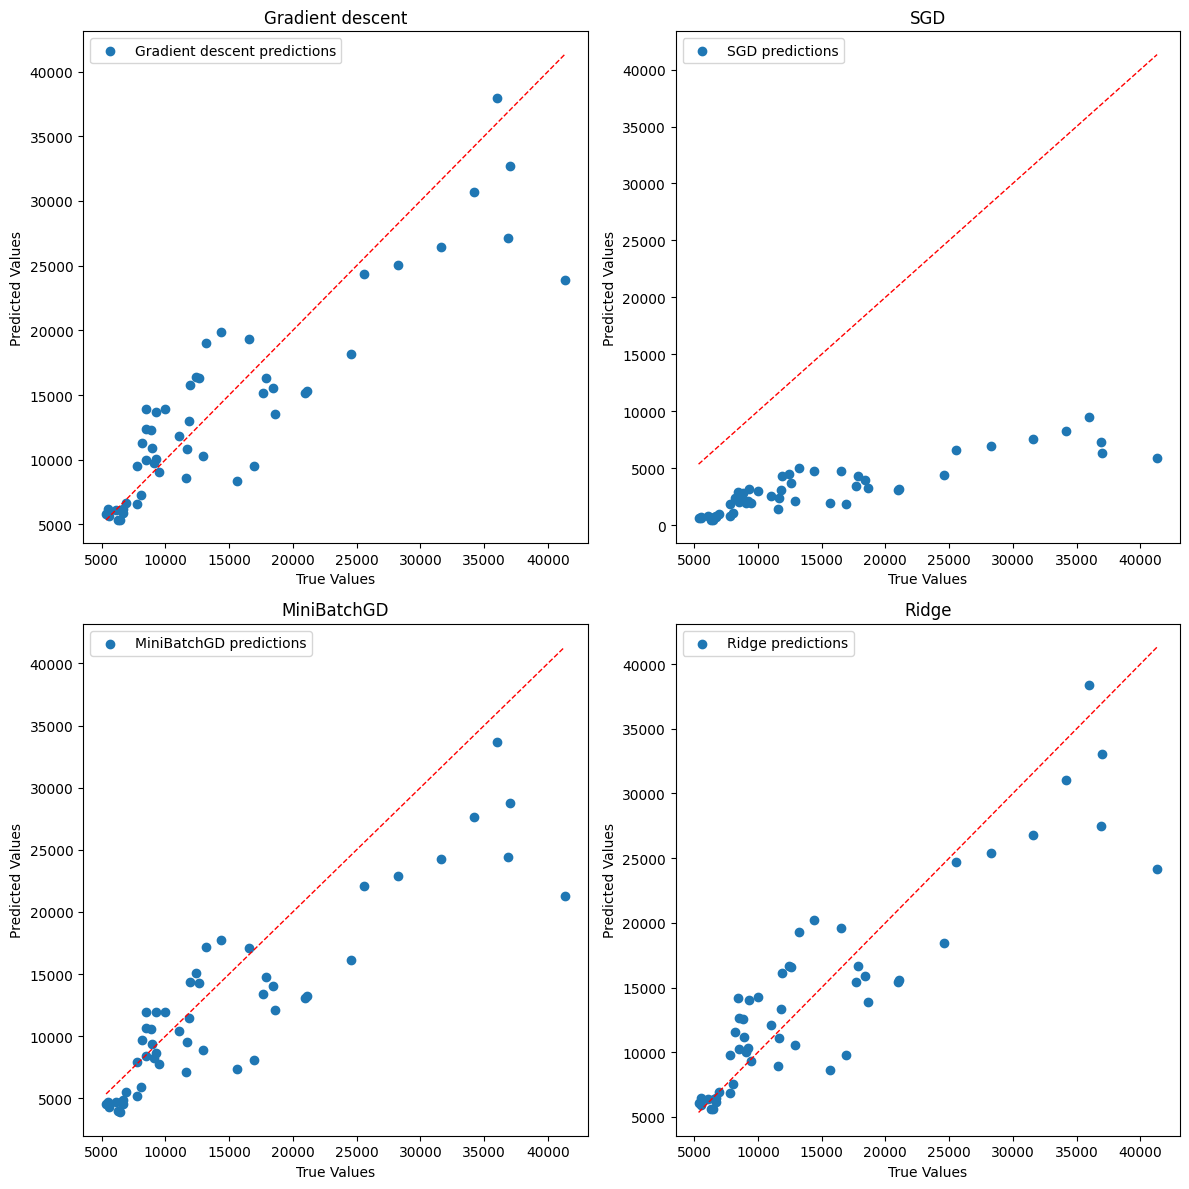

In [301]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.ravel()

for i, model_name in enumerate(predicts):
    ax[i].scatter(y_test, predicts[model_name][1], label=f"{model_name} predictions")
    ax[i].set_title(model_name)

for a in ax:
    a.set_xlabel("True Values")
    a.set_ylabel("Predicted Values")
    a.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linewidth=1, ls="--")
    a.legend()

plt.tight_layout()
plt.show()

## Кросс-валидация

In [319]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5)

results = {
    "Gradient descent": pd.DataFrame(index=[
                            'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
                        ]),
    "SGD": pd.DataFrame(index=[
                            'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
                        ]),
    "MiniBatchGD": pd.DataFrame(index=[
                            'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
                        ]),
    "Ridge": pd.DataFrame(index=[
                            'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
                        ])
}

models = {
    "Gradient descent": GDLinearRegression(alpha=opt_alpha, tol=opt_tol),
    "SGD": SGDLinearRegression(alpha=opt_alpha, tol=opt_tol),
    "MiniBatchGD": MiniBatchGDLinearRegression(alpha=opt_alpha, tol=opt_tol, batch_size=x_train_np.shape[0] // 8),
    "Ridge": Ridge(alpha=opt_alpha, tol=opt_tol)
}

for name, model in models.items():
    splited_samples = fold.split(X=x_train_np, y=y_train_np)
    for fold_i, (train_i, test_i) in enumerate(splited_samples):
        cur_x_train = x_np[train_i, :]
        cur_x_test = x_np[test_i, :]
        cur_y_train = y_np[train_i]
        cur_y_test = y_np[test_i]
        model.fit(cur_x_train, cur_y_train)

        y_predf_train = model.predict(cur_x_train)
        y_predf_test = model.predict(cur_x_test)

        mse_train = mean_squared_error(cur_y_train, y_predf_train, squared=True)
        mse_test = mean_squared_error(cur_y_test, y_predf_test, squared=True)

        rmse_train = mean_squared_error(cur_y_train, y_predf_train, squared=False)
        rmse_test = mean_squared_error(cur_y_test, y_predf_test, squared=False)

        r2_train = r2_score(cur_y_train, y_predf_train)
        r2_test = r2_score(cur_y_test, y_predf_test)

        results[name].insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
            mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test
        ])

    results[name]["E"] = results[name].mean(axis=1)
    results[name]["STD"] = results[name].std(axis=1)

In [320]:
# Для красивого отображения
pd.options.display.float_format = '{:.3f}'.format

In [321]:
results["Gradient descent"]

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,7609847.508,11255091.543,11682437.676,9722297.422,12092050.395,10472344.909,1640544.133
mse-test,31240324.778,11983422.482,11104342.470,19192253.743,84910369.729,31686142.640,27571441.901
rmse-train,2758.595,3354.861,3417.958,3118.060,3477.363,3225.367,263.345
rmse-test,5589.304,3461.708,3332.318,4380.896,9214.682,5195.782,2165.639
r2-train,0.900,0.859,0.815,0.894,0.845,0.862,0.031
r2-test,0.616,0.813,0.913,0.018,-0.087,0.455,0.412


In [322]:
results["SGD"]

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,137455977.639,135661589.861,145023237.785,134906187.909,182553350.396,147120068.718,18076417.947
mse-test,197748258.636,104320224.350,258424051.503,70302563.020,208155342.227,167790087.947,69675823.921
rmse-train,11724.162,11647.386,12042.559,11614.912,13511.231,12108.050,717.770
rmse-test,14062.299,10213.727,16075.573,8384.662,14427.590,12632.770,2864.123
r2-train,-0.804,-0.704,-1.291,-0.476,-1.345,-0.924,0.339
r2-test,-1.431,-0.631,-1.016,-2.598,-1.665,-1.468,0.667


In [323]:
results["MiniBatchGD"]

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,11142235.499,15210291.646,15576219.306,13870619.071,15756124.101,14311097.925,1716560.095
mse-test,43109410.437,14109339.882,20081963.021,9971621.754,89825114.519,35419489.922,29516311.036
rmse-train,3337.999,3900.037,3946.672,3724.328,3969.398,3775.687,235.131
rmse-test,6565.776,3756.240,4481.290,3157.787,9477.611,5487.741,2303.082
r2-train,0.854,0.809,0.754,0.848,0.798,0.812,0.036
r2-test,0.470,0.779,0.843,0.490,-0.150,0.487,0.352


In [324]:
results["Ridge"]

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,7496643.636,11136265.903,11543991.302,9565120.835,11972218.681,10342848.071,1639075.645
mse-test,28807948.735,11180076.372,10607355.842,22152277.677,27925896.293,20134710.984,7886116.586
rmse-train,2738.000,3337.104,3397.645,3092.753,3460.089,3205.118,264.697
rmse-test,5367.304,3343.662,3256.894,4706.621,5284.496,4391.795,920.242
r2-train,0.902,0.860,0.818,0.895,0.846,0.864,0.031
r2-test,0.646,0.825,0.917,-0.134,0.643,0.579,0.372


## Выводы

Реализованный градиентный спуск даёт практически идентичные результаты с библиотечной реализацией Ridge, также мини-пакетный градиентный спуск не сильно уступает по результатам решения задачи регрессии не модифицированному градиентному спуску.

В данном датасете было всего 205 значений, так что сравнивать по времени работы реализации не уместно, но стоит сказать, что стохастический градиентный спуск медленее сходился к локальным минимумам.

Также стоит отметить, что кросс-валидация не улучшила результат обучения для всех моделей.
